In [1]:
import torch
import torch.nn as nn

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import tqdm as tq
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

from torch.utils.data import TensorDataset, DataLoader
from lifelines import WeibullAFTFitter

In [2]:
from models.coDeSurv import ConsistentDeSurv
from models.DeSurv import DeSurv

## Simulating data

In [3]:
train_data = pd.read_csv("../data/posted/sim_train_star.csv")
test_data = pd.read_csv("../data/posted/sim_test.csv")

In [4]:
d1_data = train_data[train_data.OOD==0.0]
d2_data = train_data[train_data.OOD==1.0]

In [5]:
data_ood_test = test_data[test_data.OOD == 1.0]
data_id_test = test_data[test_data.OOD == 0.0]

In [6]:
x_label = ["x1", "x2"]
t_label = "Duration"
e_label = "Censor"
o_label = "OOD"

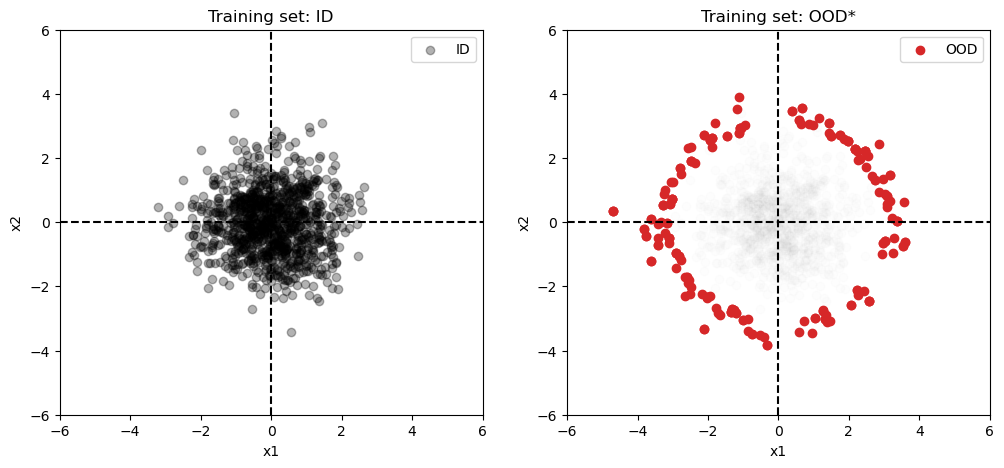

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].scatter(*d1_data[x_label].to_numpy().T, color="black", label="ID", alpha=0.3)
axs[0].set_title("Training set: ID")

axs[1].scatter(*d2_data[x_label].to_numpy().T, color="tab:red", label="OOD")
axs[1].scatter(
    *d1_data[x_label].to_numpy().T,
    color="tab:grey",
    alpha=0.01,
)
axs[1].set_title("Training set: OOD*")

for ax in axs.ravel():
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.axvline(0, linestyle="--", color="black")
    ax.axhline(0, linestyle="--", color="black")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

plt.show()

## Comparison: D1 and D2

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_duration_hist_and_cdf(d1_data: pd.DataFrame, d2_data: pd.DataFrame):
    # Extract 'Duration' columns and sort them for both datasets
    d1_duration = d1_data["Duration"].sort_values()
    d2_duration = d2_data["Duration"].sort_values()

    # Create subplots: 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the histogram on the left subplot
    ax1.hist(
        d1_duration, bins=30, color="red", alpha=0.4, label="D1", edgecolor="black"
    )
    ax1.hist(
        d2_duration, bins=30, color="blue", alpha=0.4, label="D2", edgecolor="black"
    )

    ax1.set_xlabel("Duration")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Histogram of Duration")
    ax1.legend()

    # Compute empirical CDFs
    d1_n = len(d1_duration)
    d2_n = len(d2_duration)

    d1_y_vals = np.arange(1, d1_n + 1) / d1_n
    d2_y_vals = np.arange(1, d2_n + 1) / d2_n

    # Plot the empirical CDF on the right subplot
    ax2.plot(
        d1_duration.values,
        d1_y_vals,
        marker=".",
        linestyle="none",
        color="red",
        label="D1",
    )
    ax2.plot(
        d2_duration.values,
        d2_y_vals,
        marker=".",
        linestyle="none",
        color="blue",
        label="D2",
    )

    ax2.set_xlabel("Duration")
    ax2.set_ylabel("Empirical CDF")
    ax2.set_title("Empirical CDF of Duration")
    ax2.legend()

    # Adjust layout for a cleaner appearance
    plt.tight_layout()

    # Show the plot
    plt.show()

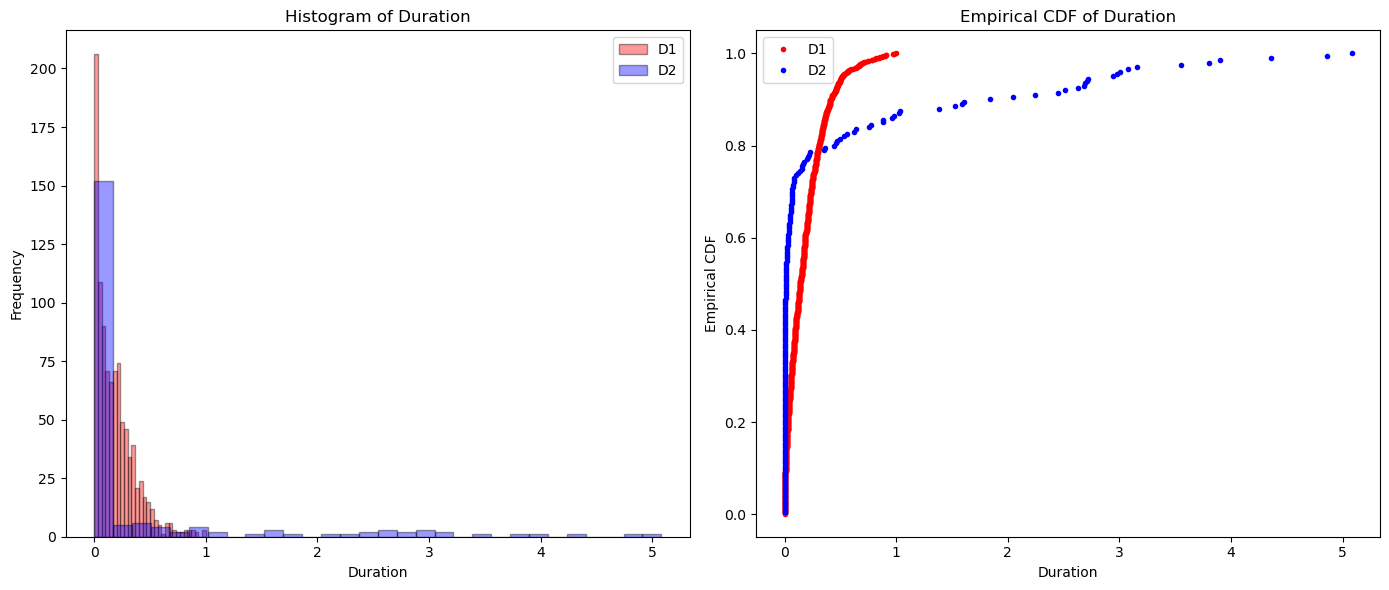

In [9]:
plot_duration_hist_and_cdf(d1_data, d2_data)


## Baseline model: AFT

In [10]:
aft = WeibullAFTFitter()
aft.fit(
    d1_data[[t_label] + [e_label] + x_label],
    duration_col=t_label,
    event_col=e_label,
    show_progress=True,
)

aft.print_summary(3)  # access the results using aft.summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.4080187055991745
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.4080187055991745
       x: [ 6.347e-01  8.139e-01 -1.469e+00  2.694e-01]
     nit: 10
     jac: [ 6.482e-07 -1.007e-06 -1.195e-07  5.001e-07]
    nfev: 11
    njev: 10


<lifelines.WeibullAFTFitter: fitted with 990 total observations, 300 right-censored observations>
             duration col = 'Duration'
                event col = 'Censor'
   number of observations = 990
number of events observed = 690
           log-likelihood = 403.939
         time fit was run = 2025-03-16 00:30:28 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ x1         0.646     1.908     0.043           0.561           0.731               1.753               2.077
        x2         0.822     2.276     0.042           0.739           0.905               2.094               2.472
        Intercept -1.469     0.230     0.029          -1.526          -1.411               0.217               0.244
rho_    Intercept  0.269     1.309     0.029           0.213           0.326               1.237               1.385

                   cmp to       z       p  -log2(p)
param   covariate                                  
lambda_ x1          0.000  14.909 <0.0005   164.569
        x2          0.000  19.419 <0.0005   276.628
        Intercept   0.000 -49.994 <0.0005       inf
rho_    Intercept   0.000   9.333 <0.0005    66.402
---
Concordance = 0.777
AIC = -799.877
log-likelihood ratio test = 363.740 on 2 df
-log2(p) of ll-ratio test = 262.383

## Evaluation (using training dataset: D1)

In [11]:
tmp = test_data[test_data.OOD == 0.0]

In [12]:
concordance_index_censored(
    tmp["Censor"] == 1.0, tmp["Duration"], -aft.predict_median(tmp)
)

(0.7871732146541307, 26708, 7221, 0, 0)

## Define necessary UDF

In [13]:
def split_dataframe(df, train_size=0.8, val_size=0.2, random_state=None):
    """
    Splits the DataFrame into train, validation, and test sets.

    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    train_size (float): Proportion of the data to be used for the training set.
    val_size (float): Proportion of the data to be used for the validation set.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: A tuple containing the train, validation, and test DataFrames.
    """
    assert train_size + val_size == 1, "Proportions must sum to 1."

    # Split the DataFrame into train and remaining sets
    df_train, df_val = train_test_split(
        df, train_size=train_size, random_state=random_state
    )

    return df_train, df_val

In [14]:
def split_df(df, x_label, t_label, e_label, o_label):
    return (
        df[x_label].values,
        df[t_label].values,
        df[e_label].values,
        df[o_label].values,
    )

In [15]:
def predict_cif(method, df):
    x_cov = torch.tensor(df[x_label].values, dtype=torch.float32)
    t = torch.tensor(df[t_label].values, dtype=torch.float32)

    cif = method.predict(x_cov, t)

    return cif

In [16]:
def compute_timediff(model, data_loader_val, n_sample, df_type, verbose):
    if df_type == "D1":
        idx_in = 1.0
        idx_ood = 0.0
    else:
        idx_in = 0.0
        idx_ood = 1.0

    reg_loss = 0
    for batch_idx, (x, t, k, o) in tq.tqdm(enumerate(data_loader_val)):
        argsort_t = torch.argsort(t)
        x_ = x[argsort_t, :].to(model.device)
        o_ = o[argsort_t].to(model.device)

        x_ood = x_[o_ == idx_ood]

        regloss = 0.0
        if x_ood.shape[0] > 0:
            _, regloss_ = model.regularisation(
                x=x_ood, verbose=verbose, n_sample=n_sample
            )
            regloss = regloss_.item()

        reg_loss += regloss

    return reg_loss

## coDeSurv: DeSurv with consistency constraint.

Data preparation step includes:
1. Split training data (i.e. D1 and D2) into train and validation set
2. Apply likelihood-based training w.r.t. D1 while regularising the model using the baseline based on D2.
3. Generate test set (D1 and D2) using the data generating process and use them for the final evaluation

First, we create train_data by combining the D1 and D2 generated above. Recall that we require indicator for the source of data (i.e., out-of-distribution / in-distribution) to determine which objective function to optimise depending on the source of D1 data will be used for consistency regularsation whereas the D2 data will be used for likelihood term. Note that the baseline model was trained on D2 and tested on D1. 

In [17]:
df_train, df_val = split_dataframe(train_data)

In [18]:
x_train, t_train, e_train, o_train = split_df(
    df_train, x_label, t_label, e_label, o_label
)
x_val, t_val, e_val, o_val = split_df(df_val, x_label, t_label, e_label, o_label)

In [19]:
batch_size = 128

In [20]:
dataset_train = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_train, torch.float32),
            (t_train, torch.float32),
            (e_train, torch.long),
            (o_train, torch.long),
        ]
    ]
)
data_loader_train = DataLoader(
    dataset_train, batch_size=batch_size, pin_memory=True, shuffle=True, drop_last=True
)

dataset_val = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_val, torch.float32),
            (t_val, torch.float32),
            (e_val, torch.long),
            (o_val, torch.long),
        ]
    ]
)
data_loader_val = DataLoader(
    dataset_val, batch_size=batch_size, pin_memory=True, shuffle=True
)

In this section, we train the model. During training, you might encounter error messages such as “Error occurred with tensor([0.9990]). Retrying…”. This error indicates that the numerical solver, which is required during the sampling step from the predicted survival time CDF, fails to converge because the simulated failure time is very close to 1. When this occurs, we simply re-sample the survival time from the CDF.

Note: it seems that this error can occur for the value not close to 1 as well. It would be important to investigate why this happens, and figure out how to make this operation more robust.

In [21]:
hidden_dim = 8
training = True
lr = 1e-3
n_epochs = 200
lambdas = [0.1, 0.5, 1.0, 1.5, 2.0]
xdim = x_train.shape[1]

In [22]:
for lambda_ in lambdas:
    codesurv = ConsistentDeSurv(
        lr,
        xdim,
        hidden_dim,
        baseline=aft,
        nonlinearity=nn.ReLU,
        device="cpu",
        n=15,
        df_columns=x_label,
    )

    if training:
        codesurv.optimize(
            data_loader_train,
            n_sample=50,
            n_epochs=n_epochs,
            logging_freq=50,
            data_loader_val=data_loader_val,
            max_wait=40,
            lambda_=lambda_,
            pretrain_epochs=20,
            verbose=True,
        )
        torch.save(codesurv.state_dict(), f"model_state/codesurv_lambda_{lambda_}_eval")
        codesurv.eval()
    else:
        state_dict = torch.load(f"model_state/codesurv_lambda_{lambda_}_eval")
        codesurv.load_state_dict(state_dict)
        codesurv.eval()

CondODENet: cpu specified, cpu used
	Epoch:  0. Total loss:      124.16
	Epoch:  0. Regularisation:        0.00
	Epoch:  0. Total val loss (i.e. regularisation):        0.00. Likelihood:       29.40
	Epoch: 50. Total loss:     -309.50
	Epoch: 50. Regularisation:       30.28
best_epoch: 50
	Epoch: 50. Total val loss (i.e. regularisation):        5.81. Likelihood:      -71.48
	Epoch: 100. Total loss:     -426.67
	Epoch: 100. Regularisation:       24.13
best_epoch: 100
	Epoch: 100. Total val loss (i.e. regularisation):        4.46. Likelihood:      -93.48
	Epoch: 150. Total loss:     -478.59
	Epoch: 150. Regularisation:       21.04
best_epoch: 150
	Epoch: 150. Total val loss (i.e. regularisation):        4.19. Likelihood:     -101.66
CondODENet: cpu specified, cpu used
	Epoch:  0. Total loss:       10.93
	Epoch:  0. Regularisation:        0.00
	Epoch:  0. Total val loss (i.e. regularisation):        0.00. Likelihood:       13.35
	Epoch: 50. Total loss:     -645.18
	Epoch: 50. Regularisati

## D1_DeSurv: Train DeSurv using only D1

In [23]:
df_train_d1, df_val_d1 = split_dataframe(d1_data)

In [24]:
x_train_d1, t_train_d1, e_train_d1, o_train_d1 = split_df(
    df_train_d1, x_label, t_label, e_label, o_label
)
x_val_d1, t_val_d1, e_val_d1, o_val_d1 = split_df(
    df_val_d1, x_label, t_label, e_label, o_label
)

In [25]:
batch_size = 128

In [26]:
dataset_train_d1 = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_train_d1, torch.float32),
            (t_train_d1, torch.float32),
            (e_train_d1, torch.long),
            (o_train_d1, torch.long),
        ]
    ]
)
data_loader_train_d1 = DataLoader(
    dataset_train_d1,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
)

dataset_val_d1 = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_val_d1, torch.float32),
            (t_val_d1, torch.float32),
            (e_val_d1, torch.long),
            (o_val_d1, torch.long),
        ]
    ]
)
data_loader_val_d1 = DataLoader(
    dataset_val_d1, batch_size=batch_size, pin_memory=True, shuffle=True
)

In [27]:
desurv = DeSurv(
    lr,
    xdim,
    hidden_dim,
    baseline=aft,
    nonlinearity=nn.ReLU,
    device="cpu",
    n=15,
    df_columns=x_label,
)

if training:
    desurv.optimize(
        data_loader_train_d1,
        n_sample=50,
        n_epochs=n_epochs,
        logging_freq=50,
        data_loader_val=data_loader_val_d1,
        max_wait=40,
    )
    torch.save(desurv.state_dict(), "model_state/desurv_eval")
    desurv.eval()
else:
    state_dict = torch.load("model_state/desurv_eval")
    desurv.load_state_dict(state_dict)
    desurv.eval()

CondODENet: cpu specified, cpu used
	Epoch:  0. Total loss:      902.35
best_epoch: 0
	Epoch:  0. Total val loss:      188.22. Regularisation:        0.00
	Epoch: 50. Total loss:      -35.50
best_epoch: 50
	Epoch: 50. Total val loss:       -8.13. Regularisation:        0.00
	Epoch: 100. Total loss:     -302.05
best_epoch: 100
	Epoch: 100. Total val loss:      -66.57. Regularisation:        0.00
	Epoch: 150. Total loss:     -381.26
best_epoch: 150
	Epoch: 150. Total val loss:      -81.55. Regularisation:        0.00


## Evaluation

1. C-index
2. Log-likelihood
3. Expected discrepancy between survival trajectories

### Prepare test set

In [28]:
x_test, t_test, e_test, o_test = split_df(test_data, x_label, t_label, e_label, o_label)

dataset_test = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_test, torch.float32),
            (t_test, torch.float32),
            (e_test, torch.long),
            (o_test, torch.long),
        ]
    ]
)

data_loader_test = DataLoader(
    dataset_test, batch_size=batch_size, pin_memory=True, shuffle=True
)

## Multiple iterations

In [29]:
co_models = {f"coDeSurv_lambda_{str(lam_).replace(".", "_")}": defaultdict(list) for lam_ in lambdas}
models = {"DeSurv": defaultdict(list), **co_models}
iterations = 30

In [30]:
for lam_ in lambdas:
    state_dict = torch.load(f"model_state/codesurv_lambda_{lam_}_eval")
    codesurv.load_state_dict(state_dict)
    codesurv.eval()
    for i in tq.tqdm(range(iterations)):
        print(f"Iteration: {i}")
        for data_type in ["D2"]:
            models[f"coDeSurv_lambda_{str(lam_).replace(".", "_")}"][f"consistency_{data_type}"].append(
                compute_timediff(
                    codesurv, data_loader_test, n_sample=50, df_type=data_type, verbose=True
                )
            )

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 0


5it [01:02, 12.59s/it]
  3%|▎         | 1/30 [01:02<30:25, 62.95s/it]

Iteration: 1


5it [01:02, 12.49s/it]
  7%|▋         | 2/30 [02:05<29:14, 62.66s/it]

Iteration: 2


5it [01:03, 12.76s/it]
 10%|█         | 3/30 [03:09<28:25, 63.18s/it]

Iteration: 3


5it [01:04, 12.94s/it]
 13%|█▎        | 4/30 [04:13<27:38, 63.78s/it]

Iteration: 4


5it [01:08, 13.70s/it]
 17%|█▋        | 5/30 [05:22<27:17, 65.49s/it]

Iteration: 5


5it [01:12, 14.53s/it]
 20%|██        | 6/30 [06:35<27:10, 67.92s/it]

Iteration: 6


5it [01:07, 13.42s/it]
 23%|██▎       | 7/30 [07:42<25:56, 67.66s/it]

Iteration: 7


5it [01:07, 13.54s/it]
 27%|██▋       | 8/30 [08:49<24:48, 67.68s/it]

Iteration: 8


5it [01:07, 13.58s/it]
 30%|███       | 9/30 [09:57<23:42, 67.75s/it]

Iteration: 9


5it [01:07, 13.58s/it]
 33%|███▎      | 10/30 [11:05<22:36, 67.80s/it]

Iteration: 10


5it [01:06, 13.36s/it]
 37%|███▋      | 11/30 [12:12<21:22, 67.50s/it]

Iteration: 11


5it [01:08, 13.76s/it]
 40%|████      | 12/30 [13:21<20:22, 67.90s/it]

Iteration: 12


5it [01:08, 13.79s/it]
 43%|████▎     | 13/30 [14:30<19:19, 68.22s/it]

Iteration: 13


5it [01:08, 13.76s/it]
 47%|████▋     | 14/30 [15:39<18:14, 68.39s/it]

Iteration: 14


5it [01:09, 13.80s/it]
 50%|█████     | 15/30 [16:48<17:08, 68.58s/it]

Iteration: 15


5it [01:08, 13.63s/it]
 53%|█████▎    | 16/30 [17:56<15:58, 68.45s/it]

Iteration: 16


5it [01:08, 13.73s/it]
 57%|█████▋    | 17/30 [19:04<14:50, 68.51s/it]

Iteration: 17


5it [01:08, 13.74s/it]
 60%|██████    | 18/30 [20:13<13:42, 68.58s/it]

Iteration: 18


5it [01:09, 13.83s/it]
 63%|██████▎   | 19/30 [21:22<12:36, 68.76s/it]

Iteration: 19


5it [01:09, 13.89s/it]
 67%|██████▋   | 20/30 [22:32<11:29, 68.97s/it]

Iteration: 20


5it [01:09, 13.80s/it]
 70%|███████   | 21/30 [23:41<10:20, 68.98s/it]

Iteration: 21


5it [01:09, 13.85s/it]
 73%|███████▎  | 22/30 [24:50<09:12, 69.07s/it]

Iteration: 22


5it [01:08, 13.72s/it]
 77%|███████▋  | 23/30 [25:59<08:02, 68.94s/it]

Iteration: 23


5it [01:08, 13.66s/it]
 80%|████████  | 24/30 [27:07<06:52, 68.74s/it]

Iteration: 24


5it [01:08, 13.68s/it]
 83%|████████▎ | 25/30 [28:15<05:43, 68.65s/it]

Iteration: 25


5it [01:08, 13.77s/it]
 87%|████████▋ | 26/30 [29:24<04:34, 68.70s/it]

Iteration: 26


5it [01:08, 13.73s/it]
 90%|█████████ | 27/30 [30:33<03:26, 68.69s/it]

Iteration: 27


5it [01:07, 13.57s/it]
 93%|█████████▎| 28/30 [31:41<02:16, 68.44s/it]

Iteration: 28


5it [01:06, 13.37s/it]
 97%|█████████▋| 29/30 [32:48<01:07, 67.97s/it]

Iteration: 29


5it [01:08, 13.61s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 0


5it [01:12, 14.40s/it]
  3%|▎         | 1/30 [01:12<34:48, 72.02s/it]

Iteration: 1


5it [01:11, 14.39s/it]
  7%|▋         | 2/30 [02:23<33:35, 71.99s/it]

Iteration: 2


5it [01:12, 14.40s/it]
 10%|█         | 3/30 [03:36<32:24, 72.01s/it]

Iteration: 3


5it [01:12, 14.48s/it]
 13%|█▎        | 4/30 [04:48<31:16, 72.17s/it]

Iteration: 4


5it [01:11, 14.39s/it]
 17%|█▋        | 5/30 [06:00<30:02, 72.10s/it]

Iteration: 5


5it [01:12, 14.41s/it]
 20%|██        | 6/30 [07:12<28:49, 72.08s/it]

Iteration: 6


5it [01:11, 14.35s/it]
 23%|██▎       | 7/30 [08:24<27:35, 71.97s/it]

Iteration: 7


5it [01:11, 14.40s/it]
 27%|██▋       | 8/30 [09:36<26:23, 71.98s/it]

Iteration: 8


5it [01:11, 14.35s/it]
 30%|███       | 9/30 [10:47<25:10, 71.92s/it]

Iteration: 9


5it [01:11, 14.37s/it]
 33%|███▎      | 10/30 [11:59<23:57, 71.90s/it]

Iteration: 10


5it [01:12, 14.53s/it]
 37%|███▋      | 11/30 [13:12<22:50, 72.14s/it]

Iteration: 11


5it [01:12, 14.50s/it]
 40%|████      | 12/30 [14:25<21:40, 72.25s/it]

Iteration: 12


5it [01:12, 14.50s/it]
 43%|████▎     | 13/30 [15:37<20:29, 72.34s/it]

Iteration: 13


5it [01:11, 14.36s/it]
 47%|████▋     | 14/30 [16:49<19:14, 72.17s/it]

Iteration: 14


5it [01:11, 14.39s/it]
 50%|█████     | 15/30 [18:01<18:01, 72.11s/it]

Iteration: 15


5it [01:12, 14.54s/it]
 53%|█████▎    | 16/30 [19:14<16:51, 72.29s/it]

Iteration: 16


5it [01:12, 14.48s/it]
 57%|█████▋    | 17/30 [20:26<15:40, 72.32s/it]

Iteration: 17


5it [01:12, 14.46s/it]
 60%|██████    | 18/30 [21:38<14:27, 72.31s/it]

Iteration: 18


5it [01:12, 14.57s/it]
 63%|██████▎   | 19/30 [22:51<13:17, 72.48s/it]

Iteration: 19


5it [01:11, 14.36s/it]
 67%|██████▋   | 20/30 [24:03<12:02, 72.27s/it]

Iteration: 20


5it [01:12, 14.45s/it]
 70%|███████   | 21/30 [25:15<10:50, 72.27s/it]

Iteration: 21


5it [01:11, 14.33s/it]
 73%|███████▎  | 22/30 [26:27<09:36, 72.09s/it]

Iteration: 22


5it [01:11, 14.23s/it]
 77%|███████▋  | 23/30 [27:38<08:22, 71.82s/it]

Iteration: 23


5it [01:12, 14.40s/it]
 80%|████████  | 24/30 [28:50<07:11, 71.88s/it]

Iteration: 24


5it [01:11, 14.38s/it]
 83%|████████▎ | 25/30 [30:02<05:59, 71.89s/it]

Iteration: 25


5it [01:12, 14.54s/it]
 87%|████████▋ | 26/30 [31:15<04:48, 72.13s/it]

Iteration: 26


5it [01:12, 14.42s/it]
 90%|█████████ | 27/30 [32:27<03:36, 72.12s/it]

Iteration: 27


5it [01:12, 14.54s/it]
 93%|█████████▎| 28/30 [33:39<02:24, 72.29s/it]

Iteration: 28


5it [01:11, 14.39s/it]
 97%|█████████▋| 29/30 [34:51<01:12, 72.19s/it]

Iteration: 29


5it [01:11, 14.39s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 0


5it [01:08, 13.69s/it]
  3%|▎         | 1/30 [01:08<33:05, 68.46s/it]

Iteration: 1


5it [01:08, 13.63s/it]
  7%|▋         | 2/30 [02:16<31:51, 68.27s/it]

Iteration: 2


5it [01:07, 13.54s/it]
 10%|█         | 3/30 [03:24<30:36, 68.02s/it]

Iteration: 3


5it [01:07, 13.50s/it]
 13%|█▎        | 4/30 [04:31<29:23, 67.81s/it]

Iteration: 4


5it [01:07, 13.55s/it]
 17%|█▋        | 5/30 [05:39<28:14, 67.80s/it]

Iteration: 5


5it [01:07, 13.50s/it]
 20%|██        | 6/30 [06:47<27:04, 67.70s/it]

Iteration: 6


5it [01:08, 13.67s/it]
 23%|██▎       | 7/30 [07:55<26:02, 67.92s/it]

Iteration: 7


5it [01:08, 13.66s/it]
 27%|██▋       | 8/30 [09:03<24:57, 68.05s/it]

Iteration: 8


5it [01:08, 13.74s/it]
 30%|███       | 9/30 [10:12<23:53, 68.25s/it]

Iteration: 9


5it [01:08, 13.65s/it]
 33%|███▎      | 10/30 [11:20<22:44, 68.25s/it]

Iteration: 10


5it [01:08, 13.64s/it]
 37%|███▋      | 11/30 [12:28<21:36, 68.24s/it]

Iteration: 11


5it [01:07, 13.60s/it]
 40%|████      | 12/30 [13:36<20:26, 68.17s/it]

Iteration: 12


5it [01:08, 13.65s/it]
 43%|████▎     | 13/30 [14:45<19:19, 68.19s/it]

Iteration: 13


5it [01:08, 13.64s/it]
 47%|████▋     | 14/30 [15:53<18:11, 68.20s/it]

Iteration: 14


5it [01:08, 13.75s/it]
 50%|█████     | 15/30 [17:02<17:05, 68.37s/it]

Iteration: 15


5it [01:08, 13.65s/it]
 53%|█████▎    | 16/30 [18:10<15:56, 68.34s/it]

Iteration: 16


5it [01:05, 13.07s/it]
 57%|█████▋    | 17/30 [19:15<14:36, 67.44s/it]

Iteration: 17


5it [01:07, 13.53s/it]
 60%|██████    | 18/30 [20:23<13:30, 67.50s/it]

Iteration: 18


5it [01:07, 13.43s/it]
 63%|██████▎   | 19/30 [21:30<12:21, 67.40s/it]

Iteration: 19


5it [01:05, 13.03s/it]
 67%|██████▋   | 20/30 [22:35<11:07, 66.73s/it]

Iteration: 20


5it [01:00, 12.08s/it]
 70%|███████   | 21/30 [23:36<09:43, 64.83s/it]

Iteration: 21


5it [01:00, 12.19s/it]
 73%|███████▎  | 22/30 [24:37<08:29, 63.67s/it]

Iteration: 22


5it [01:01, 12.38s/it]
 77%|███████▋  | 23/30 [25:39<07:21, 63.14s/it]

Iteration: 23


5it [01:01, 12.30s/it]
 80%|████████  | 24/30 [26:40<06:15, 62.65s/it]

Iteration: 24


5it [01:01, 12.20s/it]
 83%|████████▎ | 25/30 [27:41<05:10, 62.16s/it]

Iteration: 25


5it [01:01, 12.22s/it]
 87%|████████▋ | 26/30 [28:42<04:07, 61.84s/it]

Iteration: 26


5it [01:00, 12.09s/it]
 90%|█████████ | 27/30 [29:43<03:04, 61.43s/it]

Iteration: 27


5it [01:01, 12.26s/it]
 93%|█████████▎| 28/30 [30:44<02:02, 61.39s/it]

Iteration: 28


5it [01:01, 12.31s/it]
 97%|█████████▋| 29/30 [31:45<01:01, 61.43s/it]

Iteration: 29


5it [01:01, 12.33s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 0


5it [01:02, 12.45s/it]
  3%|▎         | 1/30 [01:02<30:05, 62.26s/it]

Iteration: 1


5it [01:01, 12.36s/it]
  7%|▋         | 2/30 [02:04<28:55, 61.99s/it]

Iteration: 2


5it [01:01, 12.39s/it]
 10%|█         | 3/30 [03:05<27:53, 61.96s/it]

Iteration: 3


5it [01:01, 12.34s/it]
 13%|█▎        | 4/30 [04:07<26:48, 61.86s/it]

Iteration: 4


5it [01:02, 12.46s/it]
 17%|█▋        | 5/30 [05:10<25:50, 62.02s/it]

Iteration: 5


5it [01:02, 12.54s/it]
 20%|██        | 6/30 [06:12<24:54, 62.25s/it]

Iteration: 6


5it [01:02, 12.44s/it]
 23%|██▎       | 7/30 [07:14<23:51, 62.23s/it]

Iteration: 7


5it [01:02, 12.42s/it]
 27%|██▋       | 8/30 [08:17<22:48, 62.20s/it]

Iteration: 8


5it [01:01, 12.40s/it]
 30%|███       | 9/30 [09:19<21:44, 62.13s/it]

Iteration: 9


5it [01:01, 12.33s/it]
 33%|███▎      | 10/30 [10:20<20:39, 61.98s/it]

Iteration: 10


5it [01:01, 12.27s/it]
 37%|███▋      | 11/30 [11:22<19:34, 61.80s/it]

Iteration: 11


5it [01:02, 12.47s/it]
 40%|████      | 12/30 [12:24<18:35, 61.96s/it]

Iteration: 12


5it [01:06, 13.38s/it]
 43%|████▎     | 13/30 [13:31<17:58, 63.47s/it]

Iteration: 13


5it [01:08, 13.73s/it]
 47%|████▋     | 14/30 [14:39<17:20, 65.03s/it]

Iteration: 14


5it [01:08, 13.79s/it]
 50%|█████     | 15/30 [15:48<16:33, 66.22s/it]

Iteration: 15


5it [01:08, 13.70s/it]
 53%|█████▎    | 16/30 [16:57<15:36, 66.90s/it]

Iteration: 16


5it [01:07, 13.48s/it]
 57%|█████▋    | 17/30 [18:04<14:31, 67.06s/it]

Iteration: 17


5it [01:08, 13.64s/it]
 60%|██████    | 18/30 [19:13<13:28, 67.41s/it]

Iteration: 18


5it [01:08, 13.79s/it]
 63%|██████▎   | 19/30 [20:22<12:26, 67.88s/it]

Iteration: 19


5it [01:08, 13.70s/it]
 67%|██████▋   | 20/30 [21:30<11:20, 68.08s/it]

Iteration: 20


5it [01:07, 13.43s/it]
 70%|███████   | 21/30 [22:37<10:10, 67.80s/it]

Iteration: 21


5it [01:09, 13.80s/it]
 73%|███████▎  | 22/30 [23:46<09:05, 68.17s/it]

Iteration: 22


5it [01:08, 13.68s/it]
 77%|███████▋  | 23/30 [24:55<07:57, 68.24s/it]

Iteration: 23


5it [01:08, 13.73s/it]
 80%|████████  | 24/30 [26:03<06:50, 68.37s/it]

Iteration: 24


5it [01:08, 13.70s/it]
 83%|████████▎ | 25/30 [27:12<05:42, 68.42s/it]

Iteration: 25


5it [01:08, 13.76s/it]
 87%|████████▋ | 26/30 [28:21<04:34, 68.54s/it]

Iteration: 26


5it [01:09, 13.90s/it]
 90%|█████████ | 27/30 [29:30<03:26, 68.83s/it]

Iteration: 27


5it [01:09, 13.89s/it]
 93%|█████████▎| 28/30 [30:40<02:18, 69.02s/it]

Iteration: 28


5it [01:08, 13.72s/it]
 97%|█████████▋| 29/30 [31:48<01:08, 68.89s/it]

Iteration: 29


5it [01:08, 13.73s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 0


5it [01:05, 13.12s/it]
  3%|▎         | 1/30 [01:05<31:42, 65.59s/it]

Iteration: 1


5it [01:05, 13.16s/it]
  7%|▋         | 2/30 [02:11<30:39, 65.71s/it]

Iteration: 2


5it [01:06, 13.20s/it]
 10%|█         | 3/30 [03:17<29:37, 65.85s/it]

Iteration: 3


5it [01:06, 13.24s/it]
 13%|█▎        | 4/30 [04:23<28:35, 65.98s/it]

Iteration: 4


5it [01:06, 13.23s/it]
 17%|█▋        | 5/30 [05:29<27:31, 66.05s/it]

Iteration: 5


5it [01:06, 13.25s/it]
 20%|██        | 6/30 [06:36<26:26, 66.12s/it]

Iteration: 6


5it [01:05, 13.20s/it]
 23%|██▎       | 7/30 [07:41<25:19, 66.07s/it]

Iteration: 7


5it [01:05, 13.11s/it]
 27%|██▋       | 8/30 [08:47<24:09, 65.91s/it]

Iteration: 8


5it [01:05, 13.14s/it]
 30%|███       | 9/30 [09:53<23:02, 65.84s/it]

Iteration: 9


5it [01:05, 13.12s/it]
 33%|███▎      | 10/30 [10:58<21:55, 65.78s/it]

Iteration: 10


5it [01:06, 13.31s/it]
 37%|███▋      | 11/30 [12:05<20:54, 66.02s/it]

Iteration: 11


5it [01:03, 12.67s/it]
 40%|████      | 12/30 [13:08<19:33, 65.21s/it]

Iteration: 12


5it [01:06, 13.24s/it]
 43%|████▎     | 13/30 [14:15<18:33, 65.51s/it]

Iteration: 13


5it [01:05, 13.03s/it]
 47%|████▋     | 14/30 [15:20<17:26, 65.41s/it]

Iteration: 14


5it [01:03, 12.77s/it]
 50%|█████     | 15/30 [16:24<16:14, 64.94s/it]

Iteration: 15


5it [01:06, 13.20s/it]
 53%|█████▎    | 16/30 [17:30<15:13, 65.27s/it]

Iteration: 16


5it [01:03, 12.73s/it]
 57%|█████▋    | 17/30 [18:33<14:02, 64.78s/it]

Iteration: 17


5it [01:05, 13.17s/it]
 60%|██████    | 18/30 [19:39<13:01, 65.10s/it]

Iteration: 18


5it [01:05, 13.04s/it]
 63%|██████▎   | 19/30 [20:44<11:56, 65.13s/it]

Iteration: 19


5it [01:05, 13.11s/it]
 67%|██████▋   | 20/30 [21:50<10:52, 65.26s/it]

Iteration: 20


5it [01:05, 13.12s/it]
 70%|███████   | 21/30 [22:55<09:48, 65.36s/it]

Iteration: 21


5it [01:05, 13.06s/it]
 73%|███████▎  | 22/30 [24:01<08:42, 65.35s/it]

Iteration: 22


5it [01:05, 13.17s/it]
 77%|███████▋  | 23/30 [25:07<07:38, 65.51s/it]

Iteration: 23


5it [01:05, 13.09s/it]
 80%|████████  | 24/30 [26:12<06:32, 65.49s/it]

Iteration: 24


5it [01:06, 13.29s/it]
 83%|████████▎ | 25/30 [27:18<05:28, 65.77s/it]

Iteration: 25


5it [01:06, 13.27s/it]
 87%|████████▋ | 26/30 [28:25<04:23, 65.94s/it]

Iteration: 26


5it [01:06, 13.21s/it]
 90%|█████████ | 27/30 [29:31<03:17, 65.98s/it]

Iteration: 27


5it [01:05, 13.18s/it]
 93%|█████████▎| 28/30 [30:37<02:11, 65.95s/it]

Iteration: 28


5it [01:05, 13.15s/it]
 97%|█████████▋| 29/30 [31:43<01:05, 65.89s/it]

Iteration: 29


5it [01:05, 13.09s/it]
100%|██████████| 30/30 [32:48<00:00, 65.62s/it]


In [31]:
for i in tq.tqdm(range(iterations)):
    print(f"Iteration: {i}")
    for data_type in ["D2"]:
        print(f"Iteration: {i} - D1_DeSurv - Computing the metric on {data_type}")
        models["DeSurv"][f"consistency_{data_type}"].append(
            compute_timediff(
                desurv, data_loader_test, n_sample=50, df_type=data_type, verbose=True
            )
        )

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 0
Iteration: 0 - D1_DeSurv - Computing the metric on D2


5it [01:05, 13.16s/it]
  3%|▎         | 1/30 [01:05<31:48, 65.80s/it]

Iteration: 1
Iteration: 1 - D1_DeSurv - Computing the metric on D2


5it [01:05, 13.10s/it]
  7%|▋         | 2/30 [02:11<30:37, 65.64s/it]

Iteration: 2
Iteration: 2 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.29s/it]
 10%|█         | 3/30 [03:17<29:42, 66.02s/it]

Iteration: 3
Iteration: 3 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.37s/it]
 13%|█▎        | 4/30 [04:24<28:45, 66.36s/it]

Iteration: 4
Iteration: 4 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.27s/it]
 17%|█▋        | 5/30 [05:31<27:39, 66.37s/it]

Iteration: 5
Iteration: 5 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.29s/it]
 20%|██        | 6/30 [06:37<26:33, 66.41s/it]

Iteration: 6
Iteration: 6 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.21s/it]
 23%|██▎       | 7/30 [07:43<25:24, 66.29s/it]

Iteration: 7
Iteration: 7 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.25s/it]
 27%|██▋       | 8/30 [08:49<24:18, 66.28s/it]

Iteration: 8
Iteration: 8 - D1_DeSurv - Computing the metric on D2


5it [01:05, 13.17s/it]
 30%|███       | 9/30 [09:55<23:09, 66.15s/it]

Iteration: 9
Iteration: 9 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.20s/it]
 33%|███▎      | 10/30 [11:01<22:02, 66.11s/it]

Iteration: 10
Iteration: 10 - D1_DeSurv - Computing the metric on D2


5it [01:05, 13.10s/it]
 37%|███▋      | 11/30 [12:07<20:52, 65.93s/it]

Iteration: 11
Iteration: 11 - D1_DeSurv - Computing the metric on D2


5it [01:03, 12.77s/it]
 40%|████      | 12/30 [13:11<19:35, 65.30s/it]

Iteration: 12
Iteration: 12 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.24s/it]
 43%|████▎     | 13/30 [14:17<18:34, 65.57s/it]

Iteration: 13
Iteration: 13 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.25s/it]
 47%|████▋     | 14/30 [15:23<17:32, 65.79s/it]

Iteration: 14
Iteration: 14 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.22s/it]
 50%|█████     | 15/30 [16:29<16:28, 65.88s/it]

Iteration: 15
Iteration: 15 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.28s/it]
 53%|█████▎    | 16/30 [17:36<15:24, 66.05s/it]

Iteration: 16
Iteration: 16 - D1_DeSurv - Computing the metric on D2


5it [01:05, 13.15s/it]
 57%|█████▋    | 17/30 [18:41<14:17, 65.96s/it]

Iteration: 17
Iteration: 17 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.25s/it]
 60%|██████    | 18/30 [19:48<13:12, 66.05s/it]

Iteration: 18
Iteration: 18 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.35s/it]
 63%|██████▎   | 19/30 [20:54<12:08, 66.26s/it]

Iteration: 19
Iteration: 19 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.39s/it]
 67%|██████▋   | 20/30 [22:01<11:04, 66.47s/it]

Iteration: 20
Iteration: 20 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.27s/it]
 70%|███████   | 21/30 [23:08<09:57, 66.44s/it]

Iteration: 21
Iteration: 21 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.23s/it]
 73%|███████▎  | 22/30 [24:14<08:50, 66.35s/it]

Iteration: 22
Iteration: 22 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.28s/it]
 77%|███████▋  | 23/30 [25:20<07:44, 66.36s/it]

Iteration: 23
Iteration: 23 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.39s/it]
 80%|████████  | 24/30 [26:27<06:39, 66.54s/it]

Iteration: 24
Iteration: 24 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.27s/it]
 83%|████████▎ | 25/30 [27:34<05:32, 66.48s/it]

Iteration: 25
Iteration: 25 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.34s/it]
 87%|████████▋ | 26/30 [28:40<04:26, 66.55s/it]

Iteration: 26
Iteration: 26 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.33s/it]
 90%|█████████ | 27/30 [29:47<03:19, 66.59s/it]

Iteration: 27
Iteration: 27 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.31s/it]
 93%|█████████▎| 28/30 [30:54<02:13, 66.59s/it]

Iteration: 28
Iteration: 28 - D1_DeSurv - Computing the metric on D2


5it [01:05, 13.18s/it]
 97%|█████████▋| 29/30 [31:59<01:06, 66.39s/it]

Iteration: 29
Iteration: 29 - D1_DeSurv - Computing the metric on D2


5it [01:06, 13.31s/it]
100%|██████████| 30/30 [33:06<00:00, 66.22s/it]


In [32]:
for k, v in models.items():
    for key, value in v.items():
        print(f"{k} - {key}")
        print(np.round(np.mean(value[:50]), 4), np.round(np.std(value[:50]), 4))

DeSurv - consistency_D2
22.4164 0.1874
coDeSurv_lambda_0_1 - consistency_D2
20.6104 0.1823
coDeSurv_lambda_0_5 - consistency_D2
21.815 0.2191
coDeSurv_lambda_1_0 - consistency_D2
20.1411 0.2226
coDeSurv_lambda_1_5 - consistency_D2
10.0563 0.0988
coDeSurv_lambda_2_0 - consistency_D2
20.6432 0.2088


## Predictive accuracy

In [33]:
def compute_cidx(model_name, df):
    res = 0
    if model_name == "baseline":
        res = concordance_index_censored(
            df["Censor"] == 1.0, df["Duration"], -aft.predict_median(df)
        )
    elif model_name == "DeSurv":
        res = concordance_index_censored(
            df["Censor"] == 1.0,
            df["Duration"],
            -predict_cif(desurv, df).detach().numpy(),
        )
    else:
        state_dict = torch.load(f"model_state/codesurv_lambda_{model_name}_eval")
        codesurv.load_state_dict(state_dict)
        codesurv.eval()
        
        res = concordance_index_censored(
            df["Censor"] == 1.0,
            df["Duration"],
            -predict_cif(codesurv, df).detach().numpy(),
        )
    
    return res

In [34]:
def show_cidx(model_name):
    cidx_d1, cidx_d2 = (
        compute_cidx(model_name, data_id_test),
        compute_cidx(model_name, data_ood_test),
    )

    print(f"{model_name}")
    print(f"D1: {cidx_d1[0]}, D2: {cidx_d2[0]} \n")

In [35]:
print("Predictive accuracy: c-index")

for model_name in ["baseline", "DeSurv"] + lambdas:
    show_cidx(model_name)

Predictive accuracy: c-index
baseline
D1: 0.7871732146541307, D2: 0.6639752513534416 

DeSurv
D1: 0.9037254266261899, D2: 0.8932405259087394 

0.1
D1: 0.8554186683957676, D2: 0.862815158546017 

0.5
D1: 0.8392967667776828, D2: 0.840046403712297 

1.0
D1: 0.8799257272539716, D2: 0.8761330239752514 

1.5
D1: 0.7792448937487105, D2: 0.8297602474864656 

2.0
D1: 0.7580093725131893, D2: 0.8920804331013148 

